In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
sys.path.append(os.path.abspath(os.path.join("../src")))

## Data Prep

In [3]:
from src.ingestion.preprocess import create_dataframe
from bayesian_nn import extract_features_and_target, make_dataset

In [4]:
raw_data = pd.read_csv("../data/raw_games.csv")
data = create_dataframe(raw_data)

2025-02-22 10:14:29.925 | INFO     | legacy.preprocess:create_dataframe:13 - Starting dataset creation
2025-02-22 10:14:29.929 | INFO     | legacy.preprocess:create_dataframe:113 - Home and away dataframes created succesfully
2025-02-22 10:14:29.933 | INFO     | legacy.preprocess:create_dataframe:119 - Home and away dataframes succesfully combined and grouped
2025-02-22 10:14:29.941 | INFO     | legacy.preprocess:create_dataframe:151 - Team stats succesfully merged onto game data
2025-02-22 10:14:29.942 | INFO     | legacy.preprocess:create_dataframe:156 - Duplicate columns successfully dropped
2025-02-22 10:14:29.946 | INFO     | legacy.preprocess:create_dataframe:170 - Dataset creation complete
2025-02-22 10:14:29.946 | INFO     | legacy.preprocess:create_dataframe:171 - Dataset length: 12783


In [5]:
test_seasons = ['23_24', '24_25']
val_seasons = ['21_22', '22_23']

train_data = data.loc[~data['season'].isin(test_seasons + val_seasons)].reset_index()
val_data = data.loc[data['season'].isin(val_seasons)].reset_index()

train = train_data.drop(columns=['season', 'div', 'date', 'h_team', 'a_team', 'b365h', 'b365d', 'b365a', 'ftr', 'bookies_prob'])
val = val_data.drop(columns=['season', 'div', 'date', 'h_team', 'a_team', 'b365h', 'b365d', 'b365a', 'ftr', 'bookies_prob'])

In [6]:
TARGET = 'h_win'
FEATURE_NAMES =  [col for col in train.columns if col != TARGET]
N_TRAIN = len(train)
NUM_BATCHES = 1
batch_size = int(N_TRAIN / NUM_BATCHES)

In [7]:
X_train, y_train = extract_features_and_target(train, FEATURE_NAMES, TARGET)
X_val, y_val = extract_features_and_target(val, FEATURE_NAMES, TARGET)

In [8]:
train_dataset = make_dataset(X_train, y_train, N_TRAIN, batch_size)

## Defining the Model

In [9]:
import tf_keras as tfk
from bayesian_nn import create_bnn_model
from priors_posteriors import std_normal_prior, std_normal_posterior

In [10]:
LEARNING_RATE = 0.001

In [11]:
model = create_bnn_model(
    feature_names=FEATURE_NAMES,
    hidden_units=[8, 8],
    prior=std_normal_prior,
    posterior=std_normal_posterior,
    n_train=N_TRAIN
)

In [12]:
model.compile(
    optimizer=tfk.optimizers.legacy.RMSprop(learning_rate=LEARNING_RATE),
    loss=tfk.losses.MeanSquaredError(),
    metrics=[tfk.metrics.MeanSquaredError()],
)

## Model Training

In [13]:
from helper_functions import EpochProgressBar

In [14]:
NUM_EPOCHS = 1000

In [15]:
model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS,
    callbacks=[EpochProgressBar()],
    verbose=0
)

Training Progress: 100%|██████████| 1000/1000 [00:04<00:00, 221.51epoch/s]


## Inference


In [16]:
from bayesian_nn import model_inference

In [17]:
NUM_SAMPLES = 500

In [18]:
sampled_probs = model_inference(
    model,
    X_val,
    NUM_SAMPLES,
    tag="validation"
)

Validation Output Sampling Progress: 100%|██████████| 500/500 [00:36<00:00, 13.61it/s]


## Example Output

In [19]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [20]:
random_match_idx = random.randint(0, len(val) - 1)  
match_probs = [probs[random_match_idx] for probs in sampled_probs]

home = val_data.loc[random_match_idx, 'h_team']
away = val_data.loc[random_match_idx, 'a_team']
date = val_data.loc[random_match_idx, 'date']

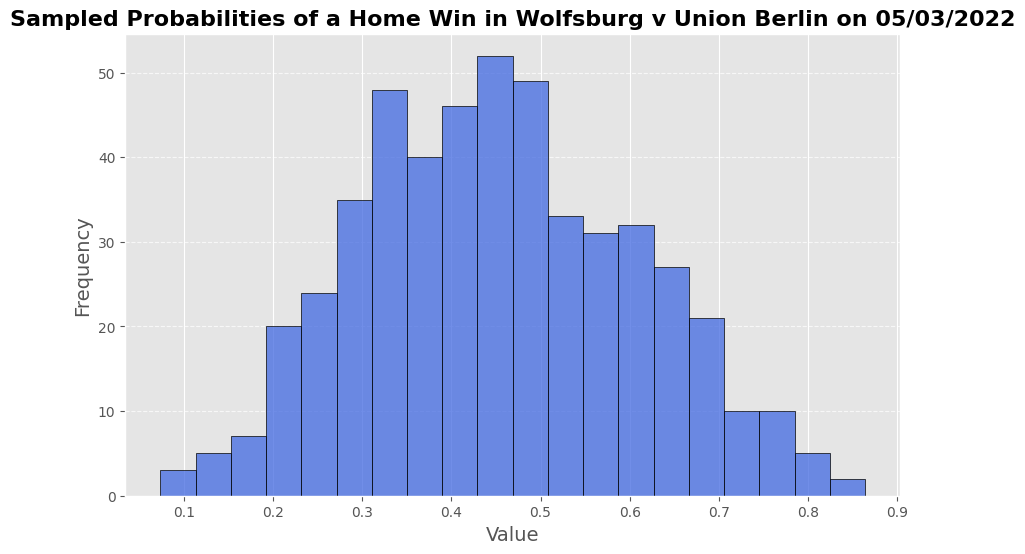

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(match_probs, bins=20, color="royalblue", edgecolor="black", alpha=0.75)

plt.title(f"Sampled Probabilities of a Home Win in {home} v {away} on {date}", fontsize=16, fontweight="bold")
plt.xlabel("Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()